# An Introduction to JAX

# GPU

This lecture was built using [hardware](https://jax.quantecon.org/status.html#status-machine-details) that has access to a GPU.

To run this lecture on [Google Colab](https://colab.research.google.com/), click on the “play” icon top right, select Colab, and set the runtime environment to include a GPU.

To run this lecture on your own machine, you need to install [Google JAX](https://github.com/google/jax).

This lecture provides a short introduction to [Google JAX](https://github.com/google/jax).

## JAX as a NumPy Replacement

One way to use JAX is as a plug-in NumPy replacement. Let’s look at the
similarities and differences.

### Similarities

The following import is standard, replacing `import numpy as np`:

In [1]:
import jax
import jax.numpy as jnp

Now we can use `jnp` in place of `np` for the usual array operations:

In [2]:
a = jnp.asarray((1.0, 3.2, 1.8))

In [3]:
print(a)

[1.  3.2 1.8]


In [4]:
print(jnp.sum(a))

6.0


In [5]:
print(jnp.mean(a))

2.0


In [6]:
print(jnp.dot(a, a))

14.4800005


However, the array object `a` is not a NumPy array:

In [7]:
a

Array([1. , 3.2, 1.8], dtype=float32)

In [8]:
type(a)

jaxlib.xla_extension.ArrayImpl

Even scalar-valued maps on arrays return JAX arrays.

In [9]:
jnp.sum(a)

Array(6., dtype=float32)

JAX arrays are also called “device arrays,” where term “device” refers to a
hardware accelerator (GPU or TPU).

(In the terminology of GPUs, the “host” is the machine that launches GPU operations, while the “device” is the GPU itself.)

Operations on higher dimensional arrays are also similar to NumPy:

In [10]:
A = jnp.ones((2, 2))
B = jnp.identity(2)
A @ B
print(A)
print(B)

n = 500
a = jnp.arange(n**2).reshape(n, n)
b = jnp.arange(n**2).reshape(n, n)

%timeit jnp.dot(a,b) #493 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
%timeit a @ b        #498 µs ± 646 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
%timeit jnp.matmul(a,b) #499 µs ± 666 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

print(jnp.dot(A,B))
print(A @ B)
print(jnp.matmul(A,B))

[[1. 1.]
 [1. 1.]]
[[1. 0.]
 [0. 1.]]
493 µs ± 4.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
496 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
496 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]


In [11]:
#Solve system of linear equations
from jax.numpy import linalg

In [12]:
linalg.solve(B, A)

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [13]:
linalg.eigh(B)  # Computes eigenvalues and eigenvectors

(Array([0.99999994, 0.99999994], dtype=float32),
 Array([[1., 0.],
        [0., 1.]], dtype=float32))

### Differences

One difference between NumPy and JAX is that, when running on a GPU, JAX uses 32 bit floats by default.

This is standard for GPU computing and can lead to significant speed gains with small loss of precision.

However, for some calculations precision matters.  In these cases 64 bit floats can be enforced via the command

In [14]:
jax.config.update("jax_enable_x64", True)

Let’s check this works:

In [15]:
jnp.ones(3)

Array([1., 1., 1.], dtype=float64)

As a NumPy replacement, a more significant difference is that arrays are treated as **immutable**.

For example, with NumPy we can write

In [16]:
import numpy as np
a = np.linspace(0, 1, 3)
a

array([0. , 0.5, 1. ])

and then mutate the data in memory:

In [17]:
a[0] = 1
a

array([1. , 0.5, 1. ])

In JAX this fails:

In [18]:
a = jnp.linspace(0, 1, 3)
a

Array([0. , 0.5, 1. ], dtype=float64)

In [19]:
a[0] = 1

TypeError: ignored

In line with immutability, JAX does not support inplace operations:

In [ ]:
a = np.array((2, 1))
a.sort()
a

In [20]:
a = jnp.array((2, 1))
a_new = a.sort()
a, a_new

(Array([2, 1], dtype=int64), Array([1, 2], dtype=int64))

The designers of JAX chose to make arrays immutable because JAX uses a
functional programming style.  More on this below.

Note that, while mutation is discouraged, it is in fact possible with `at`, as in

In [21]:
a = jnp.linspace(0, 1, 3)
id(a)

95442358740768

In [22]:
a

Array([0. , 0.5, 1. ], dtype=float64)

In [23]:
a.at[0].set(1)

Array([1. , 0.5, 1. ], dtype=float64)

We can check that the array is mutated by verifying its identity is unchanged:

In [24]:
id(a)

95442358740768

## Random Numbers

Random numbers are also a bit different in JAX, relative to NumPy.  Typically, in JAX, the state of the random number generator needs to be controlled explicitly.

In [25]:
import jax.random as random

First we produce a key, which seeds the random number generator.

In [26]:
key = random.PRNGKey(1)

In [27]:
type(key)

jaxlib.xla_extension.ArrayImpl

In [28]:
print(key)

[0 1]


Now we can use the key to generate some random numbers:

In [29]:
x = random.normal(key, (3, 3))
x

Array([[-1.35247421, -0.2712502 , -0.02920518],
       [ 0.34706456,  0.5464053 , -1.52325812],
       [ 0.41677264, -0.59710138, -0.5678208 ]], dtype=float64)

If we use the same key again, we initialize at the same seed, so the random numbers are the same:

In [30]:
random.normal(key, (3, 3))
print(key)

[0 1]


To produce a (quasi-) independent draw, best practice is to “split” the existing key:

In [31]:
key, subkey = random.split(key)
print(key)
print(subkey)

[2441914641 1384938218]
[3819641963 2025898573]


In [32]:
random.normal(key, (3, 3))

Array([[ 1.85374374, -0.37683949, -0.61276867],
       [-1.91829718,  0.27219409,  0.54922246],
       [ 0.40451442, -0.58726839, -0.63967753]], dtype=float64)

In [34]:
random.normal(subkey, (3, 3))

Array([[-0.4300635 ,  0.22778552,  0.57241269],
       [-0.15969178,  0.46719192,  0.21165091],
       [ 0.84118631,  1.18671326, -0.16607783]], dtype=float64)

The function below produces `k` (quasi-) independent random `n x n` matrices using this procedure.

In [35]:
def gen_random_matrices(key, n, k):
    matrices = []
    for _ in range(k):
        key, subkey = random.split(key)
        matrices.append(random.uniform(subkey, (n, n)))
    return matrices

In [36]:
matrices = gen_random_matrices(key, 2, 2)
for A in matrices:
    print(A)

[[0.97440813 0.3838544 ]
 [0.9790686  0.99981046]]
[[0.3473302  0.17157842]
 [0.89346686 0.01403153]]


One point to remember is that JAX expects tuples to describe array shapes, even for flat arrays.  Hence, to get a one-dimensional array of normal random draws we use `(len, )` for the shape, as in

In [37]:
random.normal(key, (5, ))

Array([-0.64377279,  0.76961857, -0.29809604,  0.47858776, -2.00591299],      dtype=float64)

## JIT Compilation

The JAX JIT compiler accelerates logic within functions by fusing linear
algebra operations into a single, highly optimized kernel that the host can
launch on the GPU / TPU (or CPU if no accelerator is detected).

Consider the following pure Python function.

In [38]:
def f(x, p=1000):
    return sum((k*x for k in range(p)))

Let’s build an array to call the function on.

In [39]:
n = 50_000_000
x = jnp.ones(n)
print(x)

[1. 1. 1. ... 1. 1. 1.]


How long does the function take to execute?

In [40]:
%time f(x).block_until_ready()

CPU times: user 536 ms, sys: 135 ms, total: 671 ms
Wall time: 11.9 s


Array([499500., 499500., 499500., ..., 499500., 499500., 499500.],      dtype=float64)

>**Note**
>
>Here, in order to measure actual speed, we use the `block_until_ready()` method
to hold the interpreter until the results of the computation are returned from
the device.

This is necessary because JAX uses asynchronous dispatch, which allows the
Python interpreter to run ahead of GPU computations.

This code is not particularly fast.

While it is run on the GPU (since `x` is a JAX array), each vector `k * x` has to be instantiated before the final sum is computed.

If we JIT-compile the function with JAX, then the operations are fused and no intermediate arrays are created.

In [41]:
f_jit = jax.jit(f)   # target for JIT compilation

Let’s run once to compile it:

In [42]:
f_jit(x)

Array([499500., 499500., 499500., ..., 499500., 499500., 499500.],      dtype=float64)

And now let’s time it.

In [43]:
%time f_jit(x).block_until_ready()

CPU times: user 5.53 ms, sys: 13 µs, total: 5.55 ms
Wall time: 933 ms


Array([499500., 499500., 499500., ..., 499500., 499500., 499500.],      dtype=float64)

Note the large speed gain.

## Functional Programming

From JAX’s documentation:

*When walking about the countryside of Italy, the people will not hesitate to tell you that JAX has “una anima di pura programmazione funzionale”.*

In other words, JAX assumes a functional programming style.

The major implication is that JAX functions should be pure.

A pure function will always return the same result if invoked with the same inputs.

In particular, a pure function has

- no dependence on global variables and  
- no side effects, for example print()


JAX will not usually throw errors when compiling impure functions but execution becomes unpredictable.

Here’s an illustration of this fact, using global variables:

In [44]:
a = 1  # global

@jax.jit
def f(x):
    return a + x

In [45]:
x = jnp.ones(2)

In [46]:
f(x)

Array([2., 2.], dtype=float64)

In the code above, the global value `a=1` is fused into the jitted function.

Even if we change `a`, the output of `f` will not be affected — as long as the same compiled version is called.

In [47]:
a = 42

In [48]:
f(x)

Array([2., 2.], dtype=float64)

Changing the dimension of the input triggers a fresh compilation of the function, at which time the change in the value of `a` takes effect:

In [49]:
x = np.ones(3)

In [50]:
f(x)

Array([43., 43., 43.], dtype=float64)

Moral of the story: write pure functions when using JAX!

## Gradients

JAX can use automatic differentiation to compute gradients.

This can be extremely useful for optimization and solving nonlinear systems.

We will see significant applications later in this lecture series.

For now, here’s a very simple illustration involving the function

In [51]:
def f(x):
    return (x**2) / 2

Let’s take the derivative:

In [52]:
f_prime = jax.grad(f)

In [53]:
f_prime(10.0)

Array(10., dtype=float64, weak_type=True)

Let’s plot the function and derivative, noting that $ f'(x) = x $.

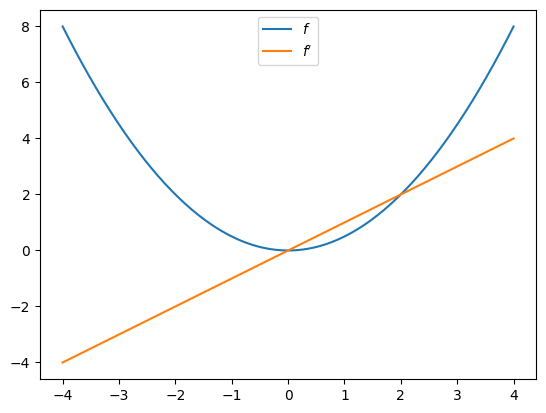

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x_grid = jnp.linspace(-4, 4, 200)
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend(loc='upper center')
plt.show()

## Exercises

## Exercise 2.1

Newton-Raphson Method
Recall that Newton’s method for solving for the root of $ f $ involves iterating on

$$
q(x) = x - \frac{f(x)}{f'(x)}
$$

Write a function called `newton` that takes a function $ f $ plus a guess $ x_0 $ and returns an approximate fixed point.

Your `newton` implementation should use automatic differentiation to calculate $ f' $.

Test your `newton` method on the function shown below.

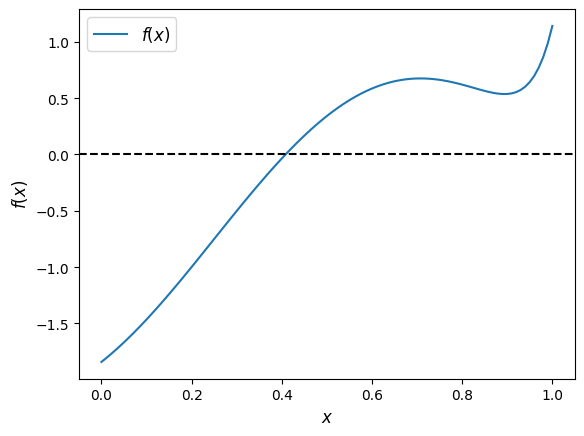

In [55]:
f = lambda x: jnp.sin(4 * (x - 1/4)) + x + x**20 - 1
x = jnp.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(x, f(x), label='$f(x)$')
ax.axhline(ls='--', c='k')
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$f(x)$', fontsize=12)
ax.legend(fontsize=12)
plt.show()

## Solution to[ Exercise 2.1](https://jax.quantecon.org/#jax_intro_ex1)

Here’s a suitable function:

In [57]:
def newton(f, x_0, tol=1e-5):
    f_prime = jax.grad(f)
    def q(x):
        return x - f(x) / f_prime(x)

    error = tol + 1
    x = x_0
    while error > tol:
        y = q(x)
        error = abs(x - y)
        x = y

    return x

Let’s try it:

In [58]:
newton(f, 0.2)

Array(0.4082935, dtype=float64, weak_type=True)

This number looks good, given the figure.

## Exercise 2.2

In [an earlier exercise on parallelization](#jax_intro_ex1), we used Monte
Carlo to price a European call option.

The code was accelerated by Numba-based multithreading.

Try writing a version of this operation for JAX, using all the same
parameters.

If you are running your code on a GPU, you should be able to achieve
significantly faster exection.

## Solution to[ Exercise 2.2](https://jax.quantecon.org/#jax_intro_ex2)

Here is one solution:

In [60]:
M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@jax.jit
def compute_call_price_jax(β=β,
                           μ=μ,
                           S0=S0,
                           h0=h0,
                           K=K,
                           n=n,
                           ρ=ρ,
                           ν=ν,
                           M=M,
                           key=jax.random.PRNGKey(1)):

    s = jnp.full(M, np.log(S0))
    h = jnp.full(M, h0)
    for t in range(n):
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (2, M))
        s = s + μ + jnp.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))

    return β**n * expectation

Let’s run it once to compile it:

In [61]:
compute_call_price_jax()

Array(180876.48840921, dtype=float64)

And now let’s time it:

In [63]:
%%time
compute_call_price_jax().block_until_ready()

CPU times: user 3 ms, sys: 1.97 ms, total: 4.96 ms
Wall time: 669 ms


Array(180876.48840921, dtype=float64)